In [1]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import KFold
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
import pandas as pd
import numpy as np
import os

In [2]:
# Set option to display all columns
pd.set_option('display.max_columns', None)
pd.set_option('display.float_format', '{:.6f}'.format)

In [3]:
categorical_features = [
    "OP_CARRIER_AIRLINE_ID",
    "TAIL_NUM",
    "OP_CARRIER_FL_NUM",

    "ORIGIN_AIRPORT_ID",
    "ORIGIN_CITY_MARKET_ID",
    "ORIGIN_STATE_FIPS",
    "ORIGIN_WAC",
    "DEST_AIRPORT_ID",
    "DEST_CITY_MARKET_ID",
    "DEST_STATE_FIPS",
    "DEST_WAC",
]

numerical_features = [
    "QUARTER",
    "MONTH",
    "DAY_OF_MONTH",
    "DAY_OF_WEEK",

    "CRS_DEP_TIME",
    "DEP_TIME_BLK",
    "CRS_ARR_TIME", 
    "ARR_TIME_BLK",
    "CRS_ELAPSED_TIME",
    "DISTANCE",
    "DISTANCE_GROUP",
]

target = "DEP_DELAY"

In [4]:
# Get the current script's directory
current_script_dir = os.getcwd()

# Move up to the parent directory
parent_dir = os.path.dirname(current_script_dir)

# Define the sibling data directory name
data_dir = os.path.join(parent_dir, 'data')

In [5]:
def set_categorical_dtype_to_str(
    dataframe: pd.DataFrame, 
    categorical_columns: list[str]
) -> pd.DataFrame:
    df = dataframe.copy()
    for column in categorical_columns:
        df[column] = df[column].astype('category')
    return df 

In [6]:
# Load the 2022 training datset
# Use os.path.join to create the full file path
training_dataset_filename = "encoded_training_dataset_2022.csv"
file_path = os.path.join(data_dir, training_dataset_filename)

# Read the CSV file into a DataFrame
dataset_df = pd.read_csv(file_path)
training_df = dataset_df[categorical_features+numerical_features+["DEP_DELAY_GROUP"]+[target]].copy()

# Set dtype of categorical features to category
training_df = set_categorical_dtype_to_str(
    dataframe=training_df, 
    categorical_columns=categorical_features
)

# Display the DataFrame
display(training_df.describe())

,QUARTER,MONTH,DAY_OF_MONTH,DAY_OF_WEEK,CRS_DEP_TIME,DEP_TIME_BLK,CRS_ARR_TIME,ARR_TIME_BLK,CRS_ELAPSED_TIME,DISTANCE,DISTANCE_GROUP,DEP_DELAY_GROUP,DEP_DELAY
count,6551773.000000,6551773.000000,6551773.000000,6551773.000000,6551773.000000,6551773.000000,6551773.000000,6551773.000000,6551773.000000,6551773.000000,6551773.000000,6551773.000000,6551773.000000
mean,2.525611,6.575482,15.731372,3.976177,1328.219585,8.024030,1486.236314,9.655784,143.059972,817.382685,3.740230,0.182563,12.603955
std,1.103255,3.387474,8.757283,2.003274,491.535391,4.865378,519.240116,4.977613,72.606267,597.402761,2.341283,2.299142,52.502743
min,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,1.000000,0.000000,1.000000,31.000000,1.000000,-2.000000,-96.000000
25%,2.000000,4.000000,8.000000,2.000000,910.000000,4.000000,1101.000000,6.000000,90.000000,386.000000,2.000000,-1.000000,-5.000000
50%,3.000000,7.000000,16.000000,4.000000,1318.000000,8.000000,1512.000000,10.000000,125.000000,666.000000,3.000000,-1.000000,-2.000000
75%,3.000000,9.000000,23.000000,6.000000,1735.000000,12.000000,1921.000000,14.000000,174.000000,1052.000000,5.000000,0.000000,10.000000
max,4.000000,12.000000,31.000000,7.000000,2359.000000,18.000000,2400.000000,18.000000,690.000000,5095.000000,11.000000,12.000000,3433.000000


In [7]:
# Load the 2023 testing datset
# Use os.path.join to create the full file path
testing_dataset_filename = "encoded_evaluation_dataset_2023.csv"
file_path = os.path.join(data_dir, testing_dataset_filename)

# Read the CSV file into a DataFrame
dataset_df = pd.read_csv(file_path)
testing_df = dataset_df[categorical_features+numerical_features+[target]].copy()

# Set dtype of categorical features to category
testing_df = set_categorical_dtype_to_str(
    dataframe=testing_df, 
    categorical_columns=categorical_features
)

# Display the DataFrame
display(testing_df.describe())

,QUARTER,MONTH,DAY_OF_MONTH,DAY_OF_WEEK,CRS_DEP_TIME,DEP_TIME_BLK,CRS_ARR_TIME,ARR_TIME_BLK,CRS_ELAPSED_TIME,DISTANCE,DISTANCE_GROUP,DEP_DELAY
count,6763366.000000,6763366.000000,6763366.000000,6763366.000000,6763366.000000,6763366.000000,6763366.000000,6763366.000000,6763366.000000,6763366.000000,6763366.000000,6763366.000000
mean,2.533025,6.599655,15.750670,3.983114,1331.043765,8.050420,1486.516154,9.665837,145.934768,833.977916,3.807604,12.285409
std,1.109902,3.412189,8.766607,2.001740,496.394849,4.914447,525.996117,5.026481,73.092890,599.873971,2.351688,55.328527
min,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,1.000000,0.000000,1.000000,21.000000,1.000000,-99.000000
25%,2.000000,4.000000,8.000000,2.000000,909.000000,4.000000,1059.000000,5.000000,92.000000,399.000000,2.000000,-5.000000
50%,3.000000,7.000000,16.000000,4.000000,1321.000000,8.000000,1515.000000,10.000000,129.000000,679.000000,3.000000,-2.000000
75%,4.000000,10.000000,23.000000,6.000000,1740.000000,12.000000,1925.000000,14.000000,176.000000,1068.000000,5.000000,9.000000
max,4.000000,12.000000,31.000000,7.000000,2359.000000,18.000000,2400.000000,18.000000,1162.000000,5095.000000,11.000000,4413.000000


## K-Fold Validation and Evaluation

In [8]:
def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

In [9]:
def evaluate_model(data_df, features_columns, target_column):
    X = data_df[features_columns].values
    y = data_df[target_column].values
    
    rmse_scores, mae_scores, errors = [], [], []

    kf = KFold(n_splits=2, shuffle=True, random_state=123)
    
    for train_index, test_index in kf.split(X):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        
        model = xgb.XGBRegressor(
            enable_categorical=True,
            objective='reg:squarederror', 
            eval_metric='rmse',
            random_state=123
        )
        model.fit(X_train, y_train)  

        y_pred = model.predict(X_test)

        errors = list(errors) + list(y_test - y_pred)

        rmse_scores.append(rmse(y_test, y_pred))
        mae_scores.append(mean_absolute_error(y_test, y_pred))
        
    return np.mean(rmse_scores), np.mean(mae_scores), errors

In [10]:
import time

# Start time
start_time = time.time()

rmse_score, mae_score, errors = evaluate_model(
    data_df=training_df, 
    features_columns=categorical_features+numerical_features, 
    target_column=target
)

print(f"Evaluation: Root Mean Squared Error: {rmse_score}")
print(f"Evaluation: Mean Absolute Error: {mae_score}")

# End time
end_time = time.time()

# Calculate elapsed time
elapsed_time = end_time - start_time
print(f"Execution time: {elapsed_time} seconds")

Evaluation: Root Mean Squared Error: 51.03979889388084
Evaluation: Mean Absolute Error: 21.367758823934853
Execution time: 64.98208737373352 seconds


In [11]:
all_groups_rmse_scores, all_groups_mae_scores = [], []

for hour in range(-2, 59, 1):
    lower_delay, upper_delay = hour*60, (hour+1)*60
    print(f"Trying model for delays between {lower_delay} and {upper_delay} minutes") 
    filtered_df = training_df[(training_df['DEP_DELAY'] >= lower_delay) & (training_df['DEP_DELAY'] < upper_delay)]
    if len(filtered_df) > 1:
        rmse_score, mae_score, errors = evaluate_model(
            data_df=filtered_df, 
            features_columns=categorical_features+numerical_features, 
            target_column=target
        )
        all_groups_rmse_scores.append(rmse_score)
        all_groups_mae_scores.append(mae_score)
        print(f"Evaluation: Root Mean Squared Error: {rmse_score}")
        print(f"Evaluation: Mean Absolute Error: {mae_score}")
    else:
        print(f"Only {len(filtered_df)} data samples found for this delay group")
    print("----------------------------------------------------------")

Trying model for delays between -120 and -60 minutes
Evaluation: Root Mean Squared Error: 9.634710019381334
Evaluation: Mean Absolute Error: 7.6414858500162754
----------------------------------------------------------
Trying model for delays between -60 and 0 minutes
Evaluation: Root Mean Squared Error: 2.7922425255227408
Evaluation: Mean Absolute Error: 2.1832955074677187
----------------------------------------------------------
Trying model for delays between 0 and 60 minutes
Evaluation: Root Mean Squared Error: 14.581328554357988
Evaluation: Mean Absolute Error: 11.62087340995038
----------------------------------------------------------
Trying model for delays between 60 and 120 minutes
Evaluation: Root Mean Squared Error: 16.96908641801838
Evaluation: Mean Absolute Error: 14.456592215805241
----------------------------------------------------------
Trying model for delays between 120 and 180 minutes
Evaluation: Root Mean Squared Error: 17.431434843654422
Evaluation: Mean Absolut

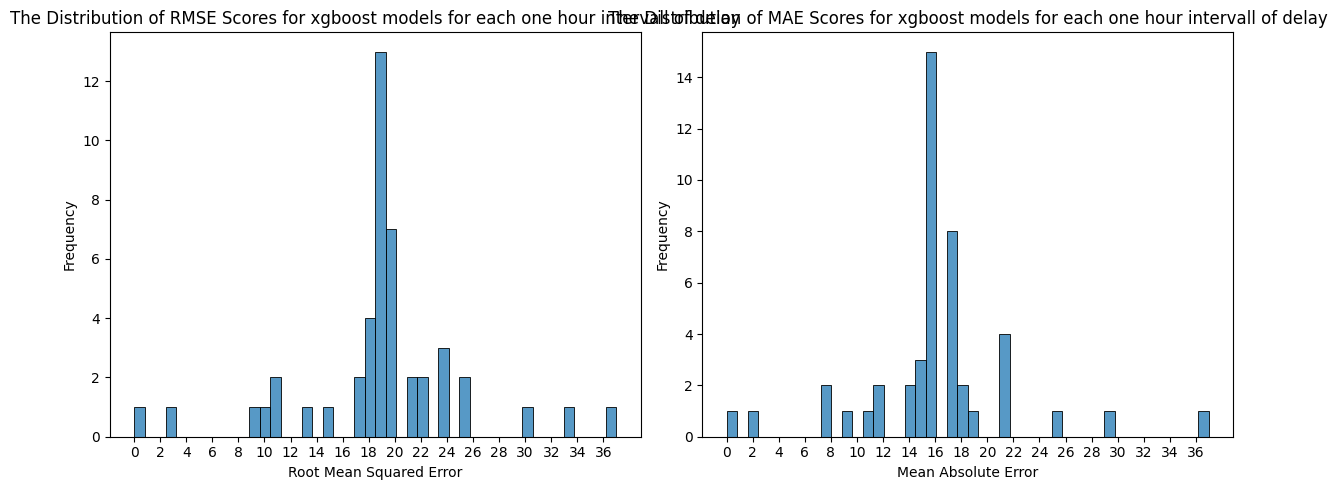

In [12]:
rounded_all_groups_rmse_scores = np.round(all_groups_rmse_scores)
rounded_all_groups_mae_scores = np.round(all_groups_mae_scores)

# Create a 1x2 subplot
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Make histogram that show the distribution of Root Mean Squared Error
sns.histplot(rounded_all_groups_rmse_scores, bins=len(rounded_all_groups_rmse_scores), ax=axes[0])
axes[0].set_title('The Distribution of RMSE Scores for xgboost models for each one hour intervall of delay')
axes[0].set_xlabel('Root Mean Squared Error')
axes[0].set_ylabel('Frequency')
min_val, max_val = min(all_groups_rmse_scores), max(all_groups_rmse_scores)
axes[0].set_xticks(np.arange(min_val, max_val + 1, 2))

# Make histogram that show the distribution of Mean Absolute Error
sns.histplot(rounded_all_groups_mae_scores, bins=len(rounded_all_groups_mae_scores), ax=axes[1])
axes[1].set_title('The Distribution of MAE Scores for xgboost models for each one hour intervall of delay')
axes[1].set_xlabel('Mean Absolute Error')
axes[1].set_ylabel('Frequency')
# Set x-axis ticks by 1 unit
min_val, max_val = min(all_groups_mae_scores), max(all_groups_mae_scores)
axes[1].set_xticks(np.arange(min_val, max_val + 1, 2))

# Adjust layout
plt.tight_layout()

# Show the plot
plt.show()

In [13]:
display(training_df.describe())

,QUARTER,MONTH,DAY_OF_MONTH,DAY_OF_WEEK,CRS_DEP_TIME,DEP_TIME_BLK,CRS_ARR_TIME,ARR_TIME_BLK,CRS_ELAPSED_TIME,DISTANCE,DISTANCE_GROUP,DEP_DELAY_GROUP,DEP_DELAY
count,6551773.000000,6551773.000000,6551773.000000,6551773.000000,6551773.000000,6551773.000000,6551773.000000,6551773.000000,6551773.000000,6551773.000000,6551773.000000,6551773.000000,6551773.000000
mean,2.525611,6.575482,15.731372,3.976177,1328.219585,8.024030,1486.236314,9.655784,143.059972,817.382685,3.740230,0.182563,12.603955
std,1.103255,3.387474,8.757283,2.003274,491.535391,4.865378,519.240116,4.977613,72.606267,597.402761,2.341283,2.299142,52.502743
min,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,1.000000,0.000000,1.000000,31.000000,1.000000,-2.000000,-96.000000
25%,2.000000,4.000000,8.000000,2.000000,910.000000,4.000000,1101.000000,6.000000,90.000000,386.000000,2.000000,-1.000000,-5.000000
50%,3.000000,7.000000,16.000000,4.000000,1318.000000,8.000000,1512.000000,10.000000,125.000000,666.000000,3.000000,-1.000000,-2.000000
75%,3.000000,9.000000,23.000000,6.000000,1735.000000,12.000000,1921.000000,14.000000,174.000000,1052.000000,5.000000,0.000000,10.000000
max,4.000000,12.000000,31.000000,7.000000,2359.000000,18.000000,2400.000000,18.000000,690.000000,5095.000000,11.000000,12.000000,3433.000000


In [14]:
# Function to categorize minutes into hourly intervals
def categorize_hour(value):
    if value < -60:
        return 0  # First hour: from -∞ to -60
    elif -60 <= value < 0:
        return 1  # Second hour: from -60 to 0
    elif 0 <= value < 60:
        return 2  # Third hour: from 0 to 60
    else:
        # Calculate the interval (starting from 4th hour for 60 to 120 minutes and so on)
        return (value // 60) + 2  # Each subsequent hour starts at multiples of 60

# Apply the function to create a new column 'hour_interval'
training_df['DELAY_HOUR_GROUPS'] = training_df['DEP_DELAY'].apply(categorize_hour)

In [15]:
# Display the result
display(training_df['DELAY_HOUR_GROUPS'].describe())

count   6551773.000000
mean          1.579605
std           1.003045
min           0.000000
25%           1.000000
50%           1.000000
75%           2.000000
max          59.000000
Name: DELAY_HOUR_GROUPS, dtype: float64

In [16]:
import time

# Start time
start_time = time.time()

rmse_score, mae_score, errors = evaluate_model(
    data_df=training_df, 
    features_columns=categorical_features+numerical_features, 
    target_column='DELAY_HOUR_GROUPS'
)

print(f"Evaluation: Root Mean Squared Error: {rmse_score}")
print(f"Evaluation: Mean Absolute Error: {mae_score}")

# End time
end_time = time.time()

# Calculate elapsed time
elapsed_time = end_time - start_time
print(f"Execution time: {elapsed_time} seconds")

Evaluation: Root Mean Squared Error: 0.9607731075604313
Evaluation: Mean Absolute Error: 0.5623739855054295
Execution time: 51.46317744255066 seconds


In [17]:
training_df['DELAY_HOUR_GROUPS'].dtype

dtype('int64')

In [18]:
training_df['DELAY_HOUR_GROUPS'] = training_df['DELAY_HOUR_GROUPS'].astype('category')

In [19]:
training_df['DELAY_HOUR_GROUPS'].dtype

CategoricalDtype(categories=[ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14,
                  15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29,
                  30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 43, 44, 45,
                  46, 47, 49, 50, 51, 54, 59],
, ordered=False, categories_dtype=int64)

In [22]:
# Define a custom F1 score evaluation function
def f1_eval(y_pred, dtrain):
    # Convert the predicted values to binary (0 or 1)
    y_true = dtrain.get_label()  # Get true labels
    y_pred_binary = (y_pred > 0.5).astype(int)  # Assuming binary classification and threshold at 0.5
    f1 = f1_score(y_true, y_pred_binary)
    return 'f1', f1

In [31]:
def evaluate_classification_model(data_df, features_columns, target_column):
    X = data_df[features_columns].values
    y = data_df[target_column].values
    
    accuracy_scores, precision_scores, recall_scores, f1_scores = [], [], [], []

    kf = KFold(n_splits=2, shuffle=True, random_state=123)
    
    for train_index, test_index in kf.split(X):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]

        label_encoder = LabelEncoder()
        y_train_mapped = label_encoder.fit_transform(y_train)
        y_test_mapped = label_encoder.fit_transform(y_test)
        
        model = xgb.XGBClassifier(
            enable_categorical=True,
            objective='multi:softmax', # multi:softmax used for multi-class
            num_class=np.unique(y_train_mapped), 
            eval_metric=f1_eval,
            random_state=123,
        )

        model.fit(X_train, y_train_mapped)

        # Predict on the test set (predictions will be in the form of 0, 1, 2, 3)
        y_pred = model.predict(X_test)

        accuracy = accuracy_score(y_test_mapped, y_pred)
        recall = recall_score(y_test_mapped, y_pred, average='weighted')  # 'micro', 'macro', 'weighted'
        precision = precision_score(y_test_mapped, y_pred, average='weighted', zero_division=0)
        f1 = f1_score(y_test_mapped, y_pred, average='weighted')

        accuracy_scores.append(accuracy)
        recall_scores.append(recall)
        precision_scores.append(precision)
        f1_scores.append(f1)
        
    return np.mean(accuracy_scores), np.mean(recall_scores), np.mean(precision_scores), np.mean(f1_scores)

In [33]:
import time
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score

# Start time
start_time = time.time()

acc_score, re_score, pre_score, f1 = evaluate_classification_model(
    data_df=training_df, 
    features_columns=categorical_features+numerical_features, 
    target_column='DELAY_HOUR_GROUPS'
)
       
print("Evaluation: Accuracy Score:", acc_score)
print("Evaluation: Recall Score:", re_score)
print("Evaluation: Precision Score:", pre_score)
print("Evaluation: F1 Score:", f1)

# End time
end_time = time.time()

# Calculate elapsed time
elapsed_time = end_time - start_time
print(f"Execution time: {elapsed_time} seconds")

KeyboardInterrupt: 